# How To Use Varix

Varix is our implementation of a variational autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extensive, because  
our pipeline works similarly for different architectures, so here we focus only on Varix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Varix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` tutorial first.

## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run the pipeline. <br><br>
2. Understand the Varix-specific **pipeline steps**. <br><br>
3. Access the Varix-specific **results** (mus, sigma, KL/MMD losses). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

Let’s get started! 🚀


## 1) Initialize and Run Varix

We set a few custom parameters of the config file. For a deep dive into the config object, see:  

`Tutorials/DeepDives/ConfigTutorial.ipynb`

#### 1.1 The Dataset

Here, we provide a mock single-cell dataset as a `MuData` object in our custom `DataPackage` structure.


In [1]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_SC
from autoencodix.configs.varix_config import VarixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

# Varix has its own config class
# with an additional loss term: either Kullback-Leibler (KL) or Maximum Mean Discrepancy (MMD)
# Instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly,
# this time with single-cell data.

print("Input data:")
print(EXAMPLE_MULTI_SC)
print("-" * 50)

my_config = VarixConfig(
    learning_rate=0.001,
    epochs=33,
    checkpoint_interval=5,
    default_vae_loss="kl",  # 'kl' or 'mmd' possible
    data_case=DataCase.MULTI_SINGLE_CELL,
)

print("\nStarting Pipeline")
print("-" * 50)
varix = acx.Varix(data=EXAMPLE_MULTI_SC, config=my_config)
result = varix.run()


Input data:
multi_sc:
  multi_sc: 1000 samples × 700 features
--------------------------------------------------

Starting Pipeline
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle'
Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class '

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 1 - Train Loss: 28.2768
Sub-losses: recon_loss: 28.2768, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 23.1285
Sub-losses: recon_loss: 23.1285, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 25.9340
Sub-losses: recon_loss: 25.9340, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 23.3480
Sub-losses: recon_loss: 23.3480, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 24.0529
Sub-losses: recon_loss: 24.0528, var_loss: 0.0001, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 22.0029
Sub-losses: recon_loss: 22.0029, var_loss: 0.0000, anneal_factor: 0.0002, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 23.0114
Sub-losses: recon_loss: 23.0113, var_loss: 0.0001, anneal_factor: 0.0003, effective_beta_factor: 0.0000
Epoch 4 - Valid Loss: 21.9849
Sub-losses: recon_loss: 21.9848,

In [2]:
result.datasets.train.metadata

,rna:cell_type,rna:batch,rna:donor,rna:cell_cycle,rna:n_genes,protein:cell_type,protein:batch,protein:donor,protein:cell_cycle,protein:n_genes
cell_1,type_0,batch3,donor4,G1,357,type_0,batch3,donor4,G1,147
cell_189,type_3,batch2,donor2,G2M,368,type_3,batch2,donor2,G2M,155
cell_19,type_3,batch1,donor1,G1,345,type_3,batch1,donor1,G1,147
cell_190,type_4,batch1,donor2,S,338,type_4,batch1,donor2,S,152
cell_191,type_0,batch3,donor2,S,349,type_0,batch3,donor2,S,150
...,...,...,...,...,...,...,...,...,...,...
cell_993,type_1,batch3,donor3,G2M,353,type_1,batch3,donor3,G2M,143
cell_994,type_1,batch1,donor3,G1,339,type_1,batch1,donor3,G1,141
cell_996,type_3,batch1,donor2,G2M,342,type_3,batch1,donor2,G2M,150
cell_998,type_1,batch2,donor4,S,341,type_1,batch2,donor4,S,146


## 2) Specific Varix Steps (with Beta Annealing Explanation)

The pipeline (`run`) does not have Varix-specific steps.  
It calls:
- preprocess  
- fit  
- predict  
- visualize  

However, the fit step works slightly differently because we have a second loss term for the distribution loss.  
This loss term can be weighted with a hyperparameter `beta` (set via config), and the weighting can be changed during training depending on the epoch via **beta annealing**.  

**Beta annealing** gradually increases the weight of the VAE distribution loss during training.  
For example, you might start with `beta=0` to let the reconstruction loss dominate early, and then gradually increase `beta` to 1 as training progresses.  
Different annealing strategies are supported, including logistic schedules, multi-phase linear or logarithmic schedules, and constant or no annealing.  
This allows more stable training and better latent space learning, especially for early epochs.

Since we're working with a variational autoencoder, we can call an additional pipeline step, `sample_latent_space`.  
The latent space inside the pipeline is sampled once from the fitted normal distribution, with one set of `mu` and `sigma` per latent dimension.  

By default, we sample from the trained model and the test data, but you can specify the split and epoch.

**ATTENTION**   <br><br>
> If you want to sample from a different split (uses data from that split as input) or epoch (uses the model at this epoch), you need to ensure you select an epoch that was checkpointed (see `checkpoint_interval` config parameter).


In [3]:
print(f"Annealing Strategy for training was: {my_config.anneal_function}")
print(f"beta hyperparam was set to: {my_config.beta}")
print("\n")
print("Starting sampling different latent spaces")
print("-"*50)
latent_spaces = {}
for i in range (4):
    latent_spaces[i] = varix.sample_latent_space()

# or
sampled = varix.sample_latent_space(split="train", epoch=4)
sampled

Annealing Strategy for training was: logistic-mid
beta hyperparam was set to: 0.1


Starting sampling different latent spaces
--------------------------------------------------


tensor([[ 1.8395e+00,  6.6451e-01,  2.5439e+00,  ..., -4.7757e-01,
          1.9421e-01, -3.0461e-01],
        [ 1.4420e+00,  1.9791e-01,  7.5252e+00,  ...,  2.2935e+00,
         -1.2755e+00,  1.5871e+00],
        [-1.4522e+00,  1.5324e+00,  1.1694e+00,  ..., -2.8710e-01,
          4.9689e-01, -1.2166e-03],
        ...,
        [ 4.6405e-01, -7.6087e-01,  1.2722e+00,  ..., -9.8709e-01,
          1.3156e+00,  2.0153e-01],
        [ 1.5879e+00,  6.8572e-01, -7.4878e-01,  ..., -1.5940e+00,
          3.7815e-01,  2.3103e-01],
        [ 1.1304e+00,  1.2235e+00, -3.2143e+00,  ...,  6.9853e-01,
         -5.4062e-01,  6.1388e-01]], device='mps:0')

## 3) Inspect Varix-Specific Results

In addition to the results that the Vanillix pipeline provided, we can access:
- Fitted distribution parameters `mu` and `sigma`  
- `total`, `reconstruction`, and `vae` losses  
- `anneal_factor`  

A note on the different loss types:  
For our variational autoencoder, the total loss consists of a reconstruction loss and a distribution loss (i.e., KL-divergence).  
To investigate these losses, the `result` object has the attribute `sub_losses`.  
This is a `LossRegistry` with the name of the loss as the key, and the value is a `TrainingDynamics` object, which can be accessed in the same way as for the Vanillix results.

For more details, check `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`.


In [4]:
sub_losses = result.sub_losses
print("Sub Losses:")
print(f"keys: {sub_losses.keys()}")
print("\n")
recon_dyn = sub_losses.get(key="recon_loss")
print("Value of reconstruction loss in epoch 4 for train split")
print(recon_dyn.get(split="train", epoch=4))

Sub Losses:
keys: dict_keys(['recon_loss', 'var_loss', 'anneal_factor', 'effective_beta_factor'])


Value of reconstruction loss in epoch 4 for train split
22.429117518833706


In [5]:
mu = result.mus.get(split="valid", epoch=9)
mu

array([[0.18310672, 0.7290277 , 0.30469728, ..., 0.183037  , 0.        ,
        0.        ],
       [0.        , 0.3284801 , 0.22641924, ..., 0.        , 0.        ,
        0.        ],
       [0.5260942 , 0.24616571, 0.66839296, ..., 0.96404535, 0.        ,
        0.        ],
       ...,
       [0.1705086 , 0.34936684, 0.4291651 , ..., 0.        , 0.04812315,
        0.        ],
       [0.27685937, 0.        , 0.57520646, ..., 0.        , 0.        ,
        0.        ],
       [0.7749893 , 0.61633545, 0.6487881 , ..., 0.10867982, 0.        ,
        0.        ]], shape=(100, 16), dtype=float32)

## 4) Show Visualizations

This follows the standard pipeline process and can be done by calling `show_result()`.  
We can also add the keyword argument `params` to `show_result()`, which colors the plots according to a metadata column.


Creating plots ...


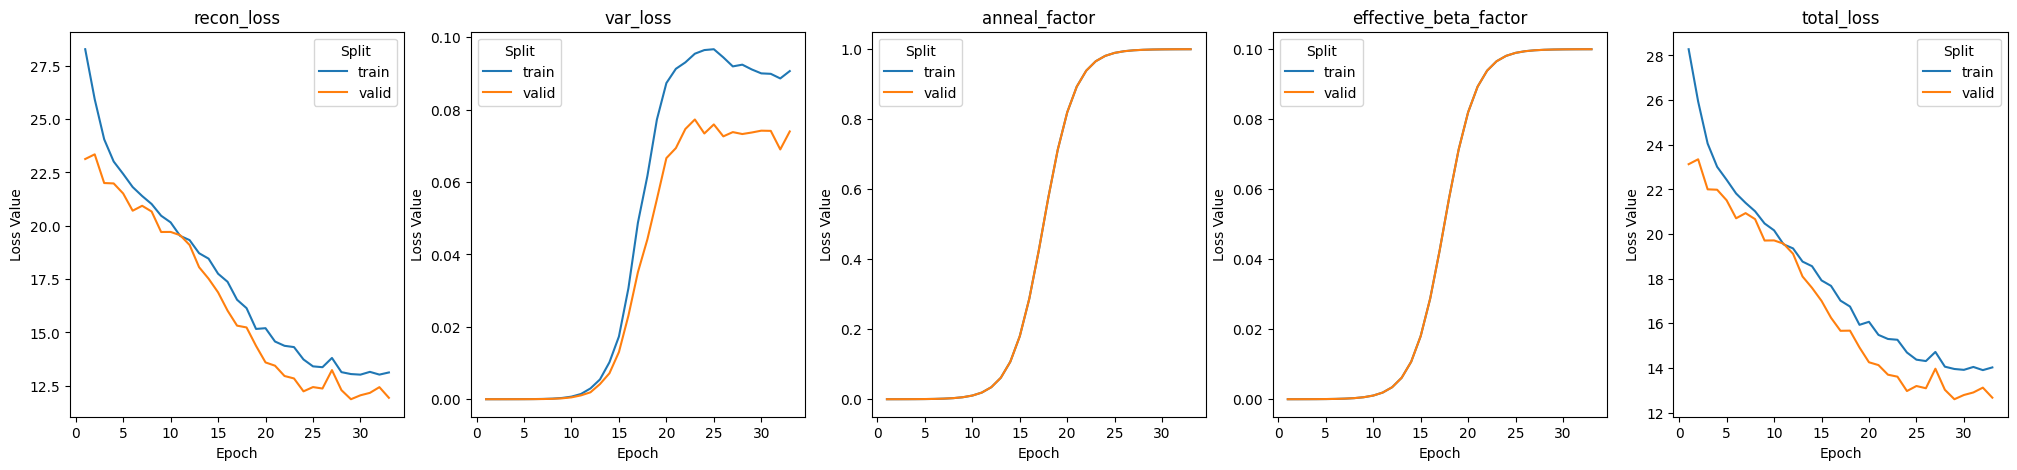

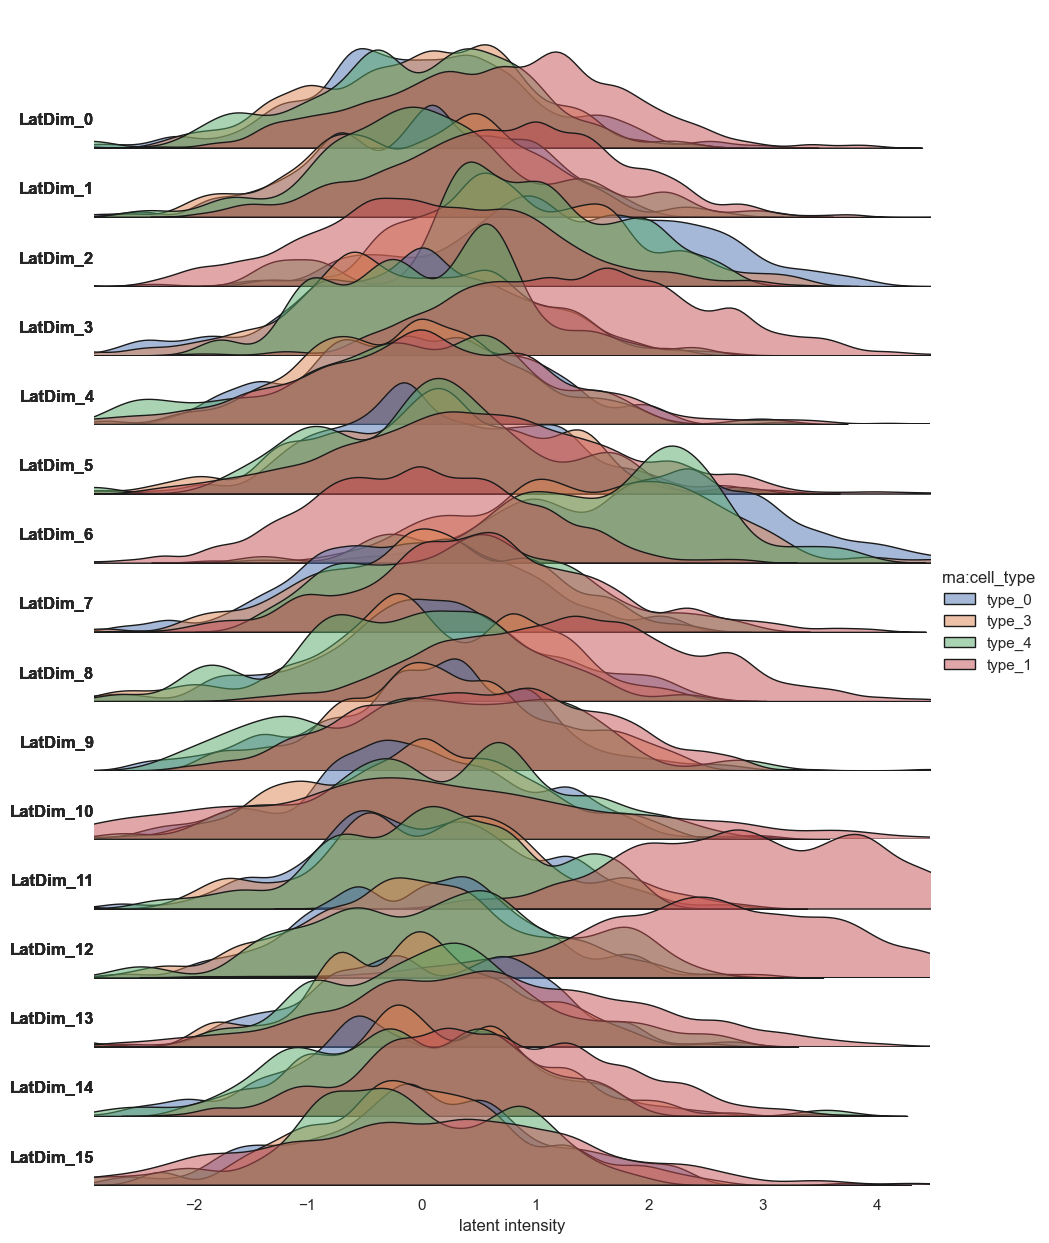

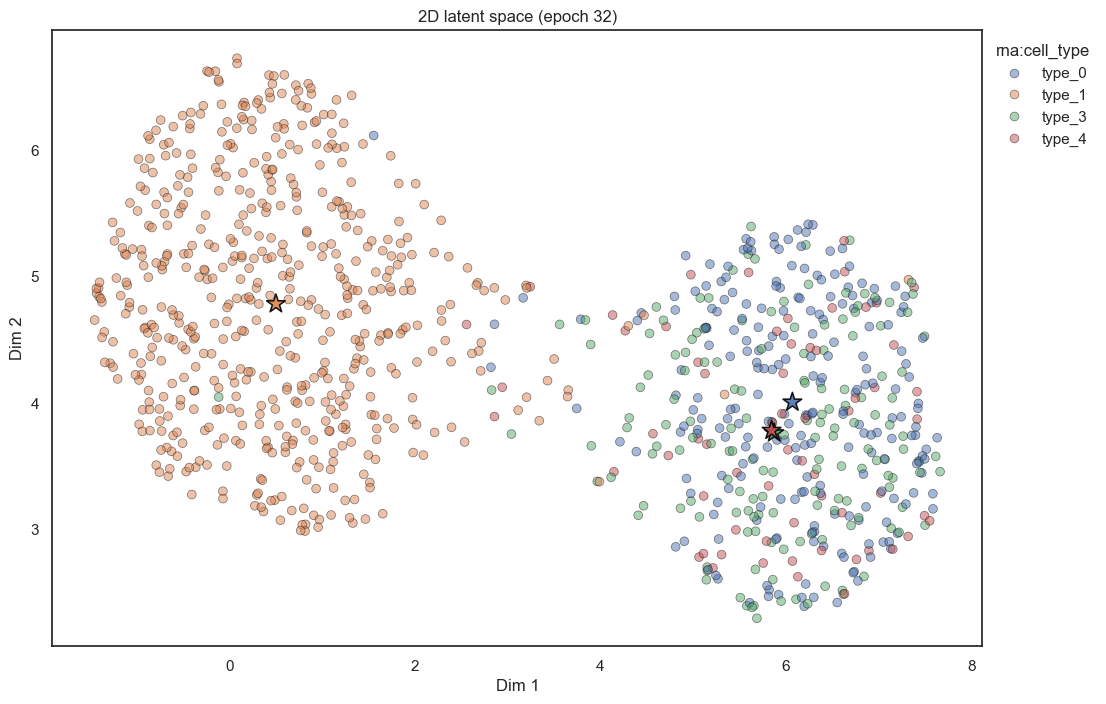

In [6]:
varix.result.datasets.test.metadata.head()

varix.show_result(params=["rna:cell_type"])

In [7]:
EXAMPLE_MULTI_SC.multi_sc["multi_sc"].obs_names

Index(['cell_0', 'cell_1', 'cell_10', 'cell_100', 'cell_101', 'cell_102',
       'cell_103', 'cell_104', 'cell_105', 'cell_106',
       ...
       'cell_990', 'cell_991', 'cell_992', 'cell_993', 'cell_994', 'cell_995',
       'cell_996', 'cell_997', 'cell_998', 'cell_999'],
      dtype='object', length=1000)

## 5) Customize Varix

To customize the behavior of our pipeline, you adjust the configuration.  
There are two ways to work with the config:

1. Create a customized instance of the config class.  
2. Provide a `yaml` file and use the config class to read it.  

We will focus on option 1 and show a few examples. For a deeper dive into configurations, please refer to `Tutorials/DeepDives/ConfigTutorial.ipynb` <br>

In this section, we demonstrate some Varix-specific parameters:
- Loss term  
- Beta  
- Annealing strategy  
- Retrieve information about all config parameters


In [8]:
from autoencodix.configs import VarixConfig
custom_config = VarixConfig(default_vae_loss="mmd", beta=1.5, anneal_function="logistic-late", data_case=DataCase.MULTI_SINGLE_CELL)
custom_varix = acx.Varix(config=custom_config, data=EXAMPLE_MULTI_SC)
result = custom_varix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
mudata: View of MuData object with n_obs × n_vars = 1000 × 700
  2 modalities
    rna:	1000 x 500
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'
    protein:	1000 x 200
      obs:	'cell_type', 'batch', 'donor', 'cell_cycle', 'n_genes'
      uns:	'log1p'


Processing 1 MuData objects: ['multi_sc']
Processing train modality: multi_sc
Processing valid split
Processing valid modality: multi_sc
Processing test split
Processing test modality: multi_sc
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
type of x in combine layers: <class 'numpy.ndarray'>
ont case
Epoch 1 - Train Loss: 28.8783
Sub-losses: recon_loss: 28.8783, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 22.5865
Sub-losses: recon_loss: 22.5865, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 25.9797
Sub-losses: recon_loss: 25.9795, var_loss: 0.0002, anneal_factor: 0.0002, effective_beta_factor: 0.0004
Epoch 2 - Valid Loss: 22.8236
Sub-losses: recon_loss: 22.8209, var_loss: 0.00

## 6) Re-use, Save, Load
There are not `Varix` specific steps here. See the `Getting Started - Vanillix` for details. Below is a basic save/load usecase:

Preprocessor saved successfully.
Model state saved successfully.
saving memory efficient
Field(name='model',type=<class 'torch.nn.modules.module.Module'>,default=<dataclasses._MISSING_TYPE object at 0x10b25e360>,default_factory=<class 'torch.nn.modules.module.Module'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Field(name='adata_latent',type=typing.Optional[anndata._core.anndata.AnnData],default=<dataclasses._MISSING_TYPE object at 0x10b25e360>,default_factory=<class 'anndata._core.anndata.AnnData'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Pipeline object saved successfully.
PKL files: ['tutorial_res/stackix.pkl', 'tutorial_res/van_preprocessor.pkl', 'tutorial_res/stackix.pkl_preprocessor.pkl', 'tutorial_res/varix.pkl_preprocessor.pkl', 'tutorial_res/van.pkl.pkl', 'tutorial_res/van.pkl_preprocessor.pkl', 'tutorial_res/van.pkl', 'tutorial_res/varix.pkl.pkl']
Model fil

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/visualize/_general_visualizer.py:51: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: Number of columns must be a positive integer, not 0
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
T

Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


<Figure size 0x500 with 0 Axes>

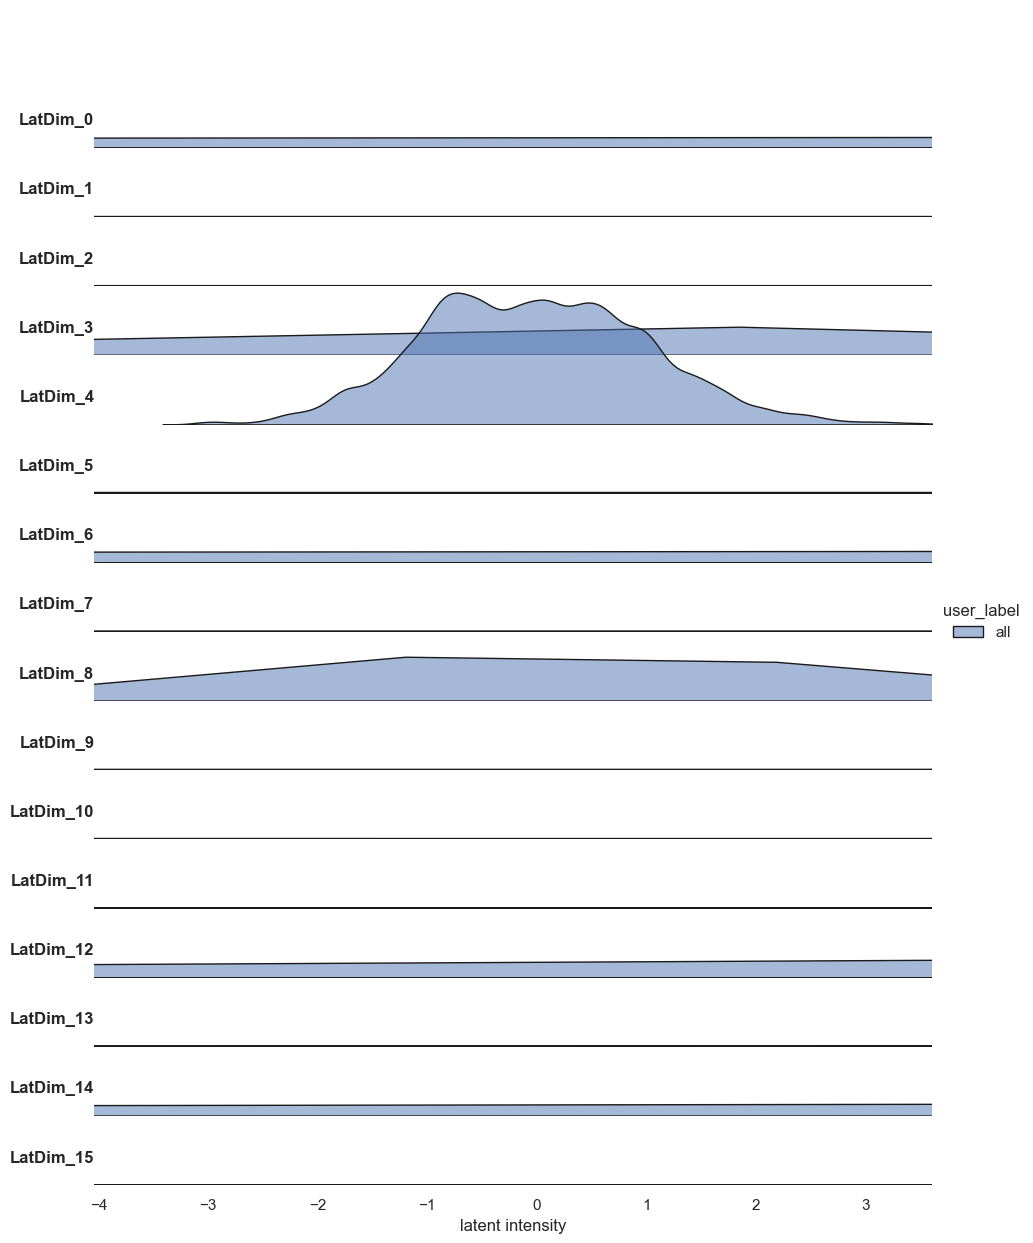

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:344: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(


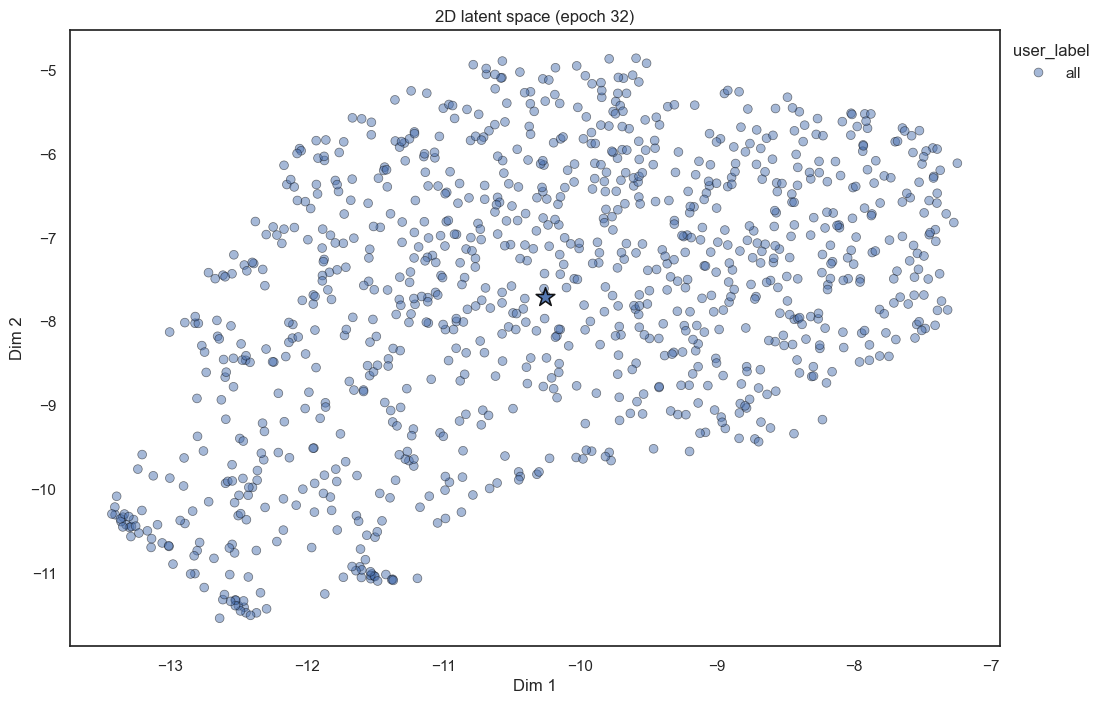

In [11]:
import os
import glob
# use a filename without extension, we handle this internally
outpath = os.path.join("tutorial_res", "varix")
varix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
varix_loaded = acx.Varix.load(outpath)
varix_loaded.predict(data=EXAMPLE_MULTI_SC)
varix_loaded.visualize()
varix_loaded.show_result()

In [12]:
varix_loaded.evaluate()

Perform ML task with feature df: Latent


AttributeError: 'NoneType' object has no attribute 'train'